In [1]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pytensor
import matplotlib.pyplot as plt
import arviz as az
import blackjax
from numba import njit
import os
import sys
import time
import errno
import timeit

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Layer DCM Implementation

### Simulation of two node and two layer

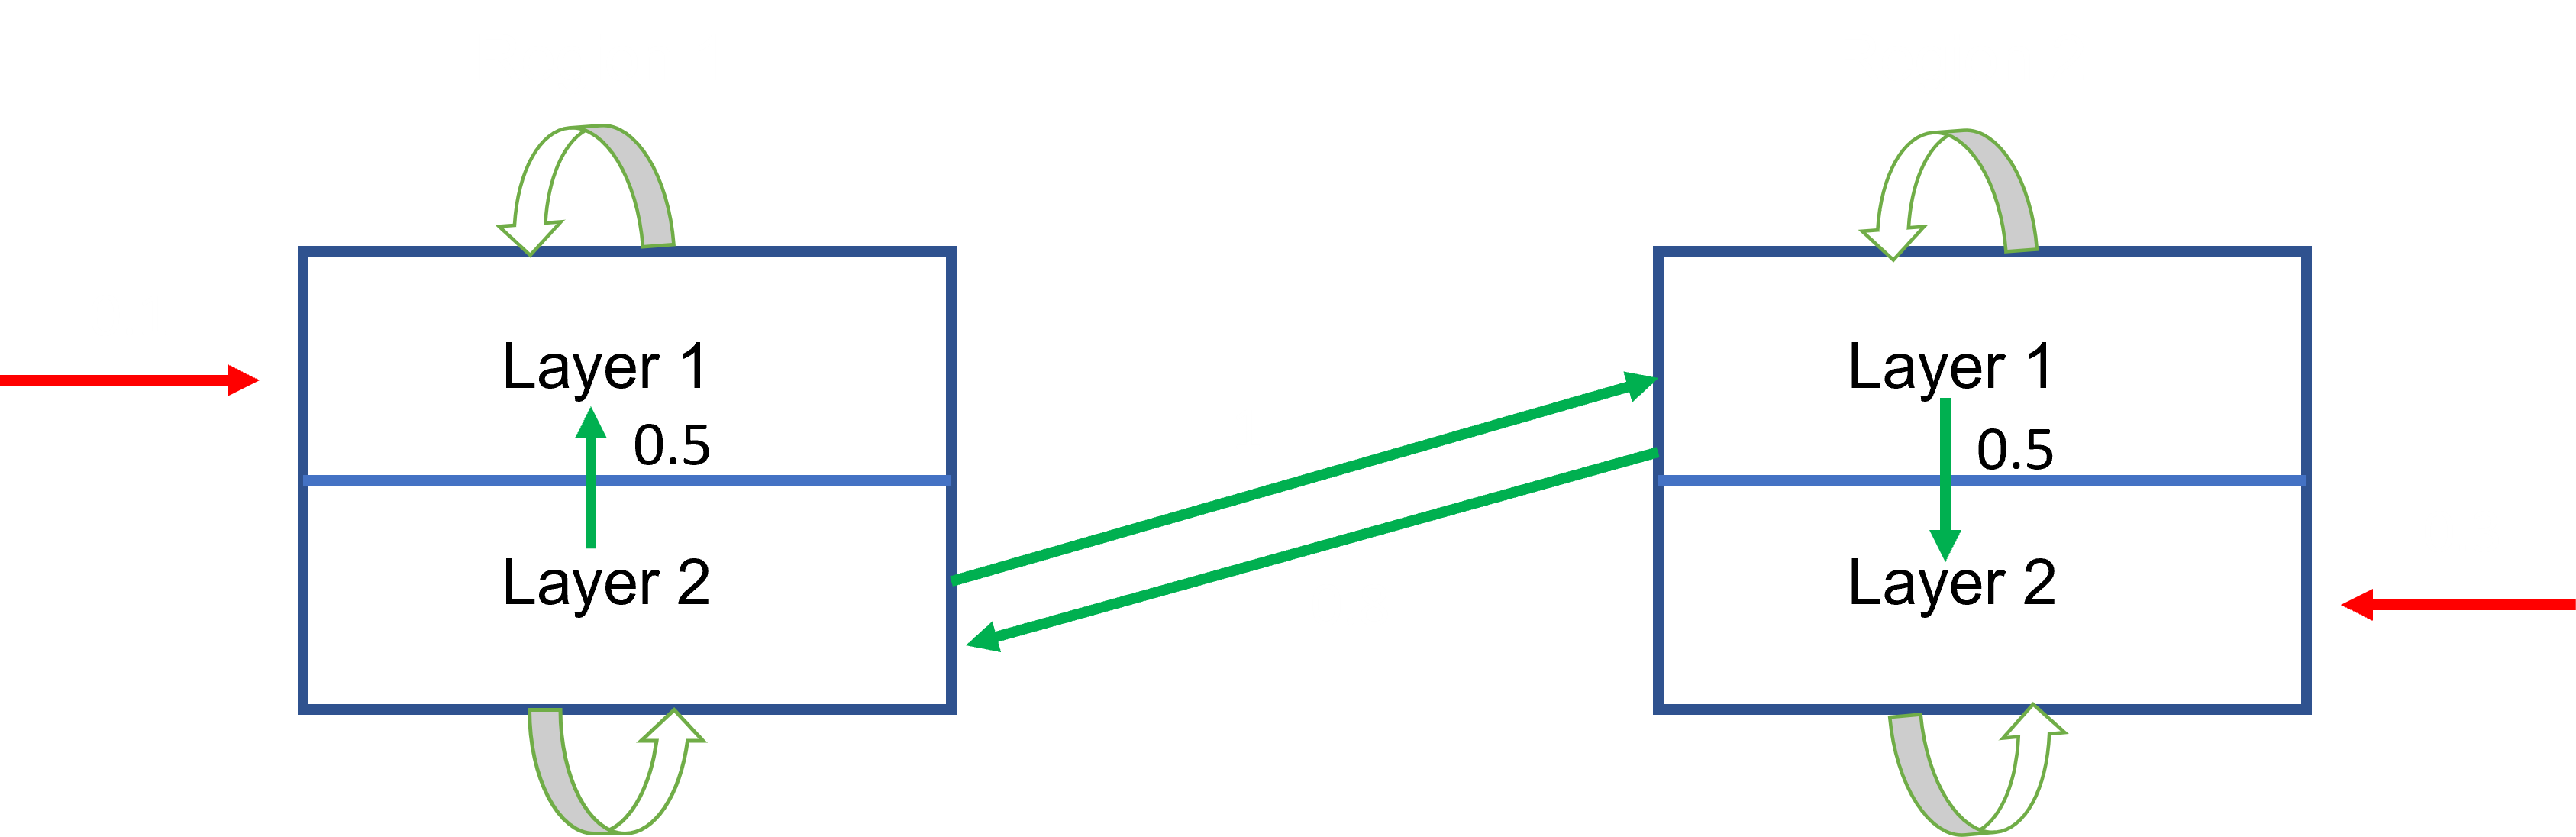

### Connectivity Param

In [69]:
num_rois = 2
num_layers = 2
self_connections = -1.

A = np.zeros([num_layers*num_rois]*2) #EXTRINS
C = np.zeros(num_layers*num_rois) #INPUT

np.fill_diagonal(A, self_connections)
paired_connections = ([(0,1),(1,0),1.], [(1,0),(0,1),0.8], [(1,0),(1,1),0.5], [(0,1),(0,0),0.5])
#   ['R0,L1->R1,L0=1.','R1,L0->R0,L1=-0.8', 'R1,L0->R1,L1->0.5']

for c in paired_connections:
    (j, lj), (i, li), v = c
    A[i+li*num_rois, j+lj*num_rois] = v
input_connections =   [(0,0,.1),(0,1,0.),(1,0,0),(1,1,.3)]
for c in input_connections:
    r, l, v = c
    C[r+l*num_rois] = v

In [71]:
A

array([[-1. ,  0. ,  0.5,  0. ],
       [ 0. , -1. ,  1. ,  0. ],
       [ 0. ,  0.8, -1. ,  0. ],
       [ 0. ,  0.5,  0. , -1. ]])

### Ballon Model Param

In [74]:
kappa = 1.92   # Neural decay.
gamma = 0.41   # Autoregulation of blood flow.
alpha = 0.32   # Stiffness parameter (outflow = volume^(1/alpha))
E0 = 0.34      # Resting oxygen extraction fraction
tau = 2.66     # Transit time (seconds)
k1 = 7. * E0
k2 = 2.
k3 = 2. * E0 - 0.2
V0 = 0.02      # Resting blood volume fraction
## Extention------------------------------------------------------
l_d   = 0.5  # coupling param
tau_d = 2.66   # delay

In [76]:
theta_true = [A, C, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0, l_d, tau_d]
#theta_true_Ballon

In [78]:
t0 = 0.0
tend = 200.0
dt = 0.1
ts = np.arange(t0, tend + dt, dt)
n_steps = len(ts)


x0 = np.zeros(num_rois*num_rois)   # neural state
s0 = np.zeros(num_rois*num_rois)   # vasodilatory signal
f0 = np.ones(num_rois*num_rois)    # blood flow
v0 = np.ones(num_rois*num_rois)    # blood volume
q0 = np.ones(num_rois*num_rois)    # deoxyhemoglobin content
qvs0 = np.zeros(num_rois*num_rois)
init_state = np.concatenate([x0, s0, f0, v0, q0, qvs0])  # shape: (5*num_node,)

In [80]:
def stim_boxcar_pytensor(t, onsets, durations, amplitudes):
    """Boxcar stimulus function compatible with PyTensor"""
    u_t = 0
    for i in range(len(onsets)):
        u_t += pt.switch(pt.and_(t >= onsets[i], t <= (onsets[i] + durations[i])), amplitudes[i], 0)
    return u_t

### Model with PyMc

In [83]:
def model_scan_simulation(theta,  onsets, durations, amplitudes, num_node,num_layers, dt=0.1):
    with pm.Model() as model:
        A, C, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0, l_d, tau_d= theta

        def ode_update_function(t, state, A, C, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0, l_d, tau_d):
            
            x = state[0:num_node*num_layers]
            s = state[num_node*num_layers:2*num_node*num_layers]
            f = state[2*num_node*num_layers:3*num_node*num_layers]
            v = state[3*num_node*num_layers:4*num_node*num_layers]
            q = state[4*num_node*num_layers:5*num_node*num_layers]
            vqs = state[5*num_node*num_layers:6*num_node*num_layers]
            vs = vqs[:num_rois]   
            qs = vqs[num_rois:] 
            #vs, qs = np.array_split(vqs,num_layers)
            
            stimulus = stim_boxcar_pytensor(t, onsets, durations, amplitudes)
            #A_mat = pt.stack([[A1, A2], [A3, A4]])
            #C_vec = pt.stack([C1, C2])
            #stimulus = 
            dx_dt = pt.dot(A, x) + C * stimulus
            # dx_dt = pt.dot(A, x) + pt.dot(C, stimulus)
            # Hemodynamic state updates 
            dsdt = x - kappa * s - gamma * (f - 1)
            dfdt = s
            #drain_v = np.r_[0*vs,l_d*vs]
            #drain_q = np.r_[0*qs,l_d*qs]
            drain_v = pt.concatenate([pt.zeros_like(vs), l_d * vs])
            drain_q = pt.concatenate([pt.zeros_like(qs), l_d * qs])
            dvdt = (1/tau)*(f-v**(1/alpha)) + drain_v
            dqdt = (1/tau)*(f*(1-(1-E0)**(1/f))/E0-v**(1/alpha-1)*q) + drain_q
            
            # Delay equations: split v and q into layers (take first half as "layer 1")
            vl = v[:num_rois]
            ql = q[:num_rois]
            dvsdt = (1/tau_d) * (-vs + (vl - 1))
            dqsdt = (1/tau_d) * (-qs + (ql - 1))


            x_new = x + dt * dx_dt
            s_new = s + dsdt * dt
            f_new = f + dfdt * dt
            v_new = v + dvdt * dt
            q_new = q + dqdt * dt
            vs_new = vs + dvsdt * dt
            qs_new = qs + dqsdt * dt


            #new_state = pt.concatenate([new_x, s_new, f_new, v_new, q_new])
            #new_state = pt.concatenate([x_new, s_new, f_new, v_new, q_new, dvsdt_new, dqsdt_new])
            vqs_new = pt.concatenate([vs_new, qs_new])
            new_state = pt.concatenate([x_new, s_new, f_new, v_new, q_new, vqs_new])
            return new_state

        init_state_tensor = pt.as_tensor_variable(init_state)
        t_vals = pt.arange(n_steps, dtype="float64")
        result, updates = pytensor.scan(
            fn=ode_update_function,
            sequences=[t_vals],  
            outputs_info= [init_state_tensor],
            non_sequences=[A, C, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0,  l_d, tau_d],
            n_steps=n_steps
        )

        f_result = result[:, 2*num_node*num_layers:3*num_node*num_layers]
        v_result = result[:, 3*num_node*num_layers:4*num_node*num_layers]
        q_result = result[:, 4*num_node*num_layers:5*num_node*num_layers]
        bold = V0 * (k1 * (1 - q_result) + k2 * (1 - q_result/v_result) + k3 * (1 - v_result))

        

        # Save the computed BOLD signal as a deterministic variable.
        pm.Deterministic("bold",  bold)
        
    return model


Sampling: []


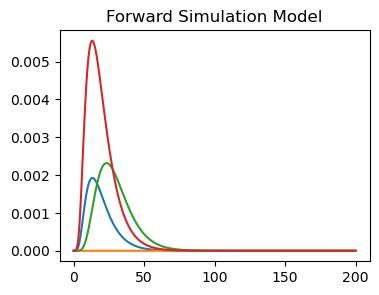

In [85]:
# Example of creating the model:
model = model_scan_simulation(theta_true,[0],[30],[1], num_rois, num_layers, dt=0.05)

fig, ax = plt.subplots(figsize=(4, 3))
with model:
    # Sample prior predictive to get the BOLD signal
    simul = pm.sample_prior_predictive(1).prior.bold[0][0].values
    ax.plot(ts, simul, label=f"BOLD Signal {i+1}")

ax.set_title("Forward Simulation Model");

### Adding Noise to forward model

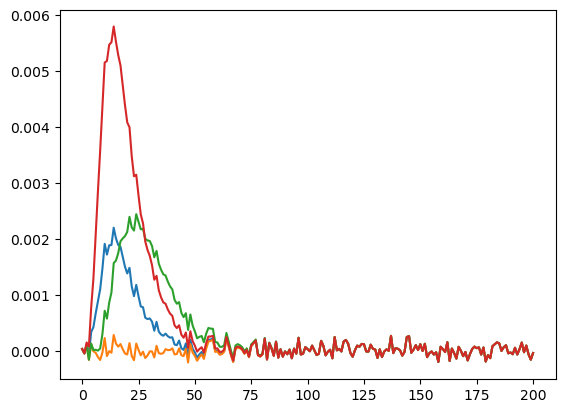

In [104]:
ROI1_1 = simul[:,0]
ROI1_2 = simul[:,1]
ROI2_1 = simul[:,2]
ROI2_2 = simul[:,3]

ds=10
ts_obs=ts[::ds]
xpy_ds_1_1=ROI1_1[::ds].flatten()
xpy_ds_1_2=ROI1_2[::ds].flatten()
xpy_ds_2_1=ROI2_1[::ds].flatten()
xpy_ds_2_2=ROI2_2[::ds].flatten()

sigma_true=0.0001
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_ds_1_1.shape[0])

xpy_obs = xpy_ds_1_1 + x_noise
xpy_obs2 = xpy_ds_1_2 + x_noise
xpy_obs3 = xpy_ds_2_1 + x_noise
xpy_obs4 = xpy_ds_2_2 + x_noise
plt.plot(np.arange(201), xpy_obs)
plt.plot(np.arange(201), xpy_obs2)
plt.plot(np.arange(201), xpy_obs3)
plt.plot(np.arange(201), xpy_obs4)


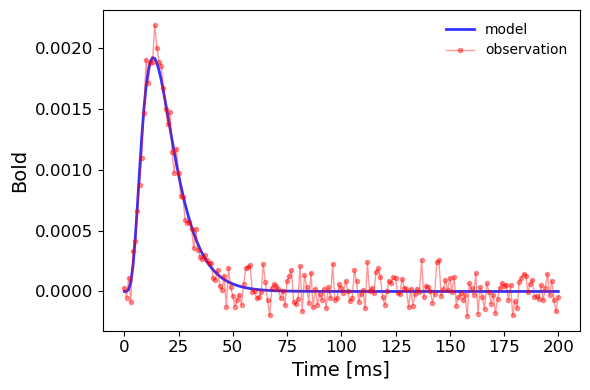

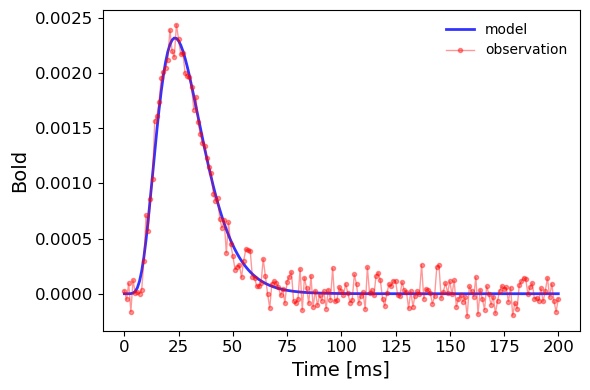

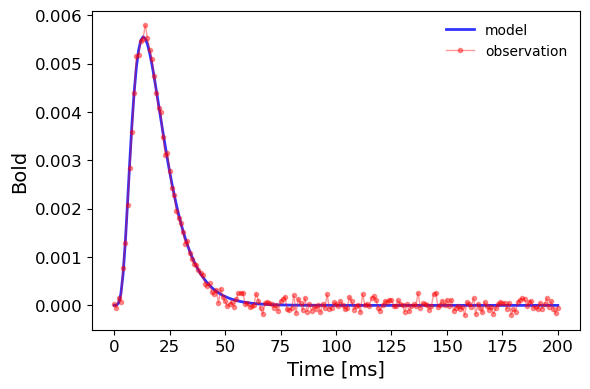

In [109]:
def plot_observation(ts_model, xpy_model, ts_obs, xpy_obs):
    plt.figure(figsize=(6,4))
    plt.plot(ts_model, xpy_model, color="b", lw=2,  alpha=0.8, label='model');
    plt.plot(ts_obs, xpy_obs, color="red", lw=1, marker=".", alpha=0.4, label='observation');
    plt.legend(fontsize=10, frameon=False, loc='upper right')
    plt.ylabel('Bold', fontsize=14); 
    plt.xlabel('Time [ms]', fontsize=14); 
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout();
    #plt.savefig(os.path.join((output_dir),"Observation.png"), dpi=800)

plot_observation(ts_obs, xpy_ds_1_1, ts_obs, xpy_obs);
#plot_observation(ts_obs, xpy_ds_1_2, ts_obs, xpy_obs2);
plot_observation(ts_obs, xpy_ds_2_1, ts_obs, xpy_obs3);
plot_observation(ts_obs, xpy_ds_2_2, ts_obs, xpy_obs4);

### Defining Priors